#Weather Prediction System using Bayesian Networks
Assignment Objective: Predict weather conditions based on past data points

Made by:
- EL YOUSFI-ALAOUI Mohammed
- El Ajjouri Safaa
- Tlemcani chayma
- Motassim ahmed taha

In [63]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\tmmot\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from sklearn.metrics import accuracy_score


# Step 1: Importing Data
-Loading the Weather Dataset, containing hourly weather forecasting.

-Discrete and continuous variables include precipitation type, temperature, humidity, wind speed, and more


In [99]:
df = pd.read_csv('weatherHistory.csv')
#df.set_index("Formatted Date", inplace=True)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [100]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

# Step 2: Data Cleaning
-Ensuring data integrity by removing missing values (NAs)

-Analyzing relationships between variables by calculating the correlation matrix

-Aggregating data for better analysis and model training

-Discretizing continuous values to transform them into categorical variables

In [104]:
# Convert the 'Formatted Date' column to datetime format
# The format argument specifies the current format of the dates in the column
# The errors argument is set to 'coerce' to handle any errors during conversion by setting them to NaT (Not a Time)
# The utc argument is set to True to convert the datetime to UTC
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], format="%Y-%m-%d %H:%M:%S.%f %z", errors='coerce', utc=True)

# Extract the date part from the 'Formatted Date' column
df['Formatted Date'] = df['Formatted Date'].dt.date

# Convert the 'Formatted Date' column back to datetime format
# This is done because the previous operation converted the column to object type
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [105]:
print(df['Formatted Date'].dtype)

datetime64[ns]


In [106]:
df['Daily Summary'].describe()

count                                 96453
unique                                  214
top       Mostly cloudy throughout the day.
freq                                  20085
Name: Daily Summary, dtype: object

In [107]:
df['Precip Type'].value_counts()

Precip Type
rain    85224
snow    10712
Name: count, dtype: int64

In [108]:
# Pre-processing

# Check for missing values (NaNs) in the dataframe 'df'
# The isnull() function returns a dataframe of True/False values indicating whether each value is missing or not
# The sum() function then sums these boolean values, giving the total number of missing values in each column
print(df.isnull().sum())

# Print the total number of rows in the dataframe 'df'
print(len(df))

# Remove rows with missing values in the 'Precip Type' column
# The dropna() function is used with the subset argument to specify the column to check for missing values
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.dropna(subset=['Precip Type'], inplace=True)

print("\n")
# Check for missing values (NaNs) in the dataframe 'df' again, after removing rows with missing 'Precip Type'
print(df.isnull().sum())

# Print the total number of rows in the dataframe 'df' after removing rows with missing 'Precip Type'
print(len(df))
df.head()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64
96453


Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64
95936


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [109]:
# Remove the 'Summary' column from the dataframe 'df'
# The drop() function is used with the axis argument set to 1 to specify that a column (not a row) is being dropped
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.drop('Summary' , axis = 1 , inplace = True)

In [110]:
#Check loud Cover
df['Loud Cover'].describe()

count    95936.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Loud Cover, dtype: float64

In [111]:
# The output shows that all values in the 'Loud Cover' column are 0.0, which means this column provides no useful information

# Remove the 'Loud Cover' column from the dataframe 'df'
# The drop() function is used with the axis argument set to 1 to specify that a column (not a row) is being dropped
# The inplace argument is set to True to modify the original dataframe 'df' directly
df.drop('Loud Cover' , axis = 1 , inplace = True)

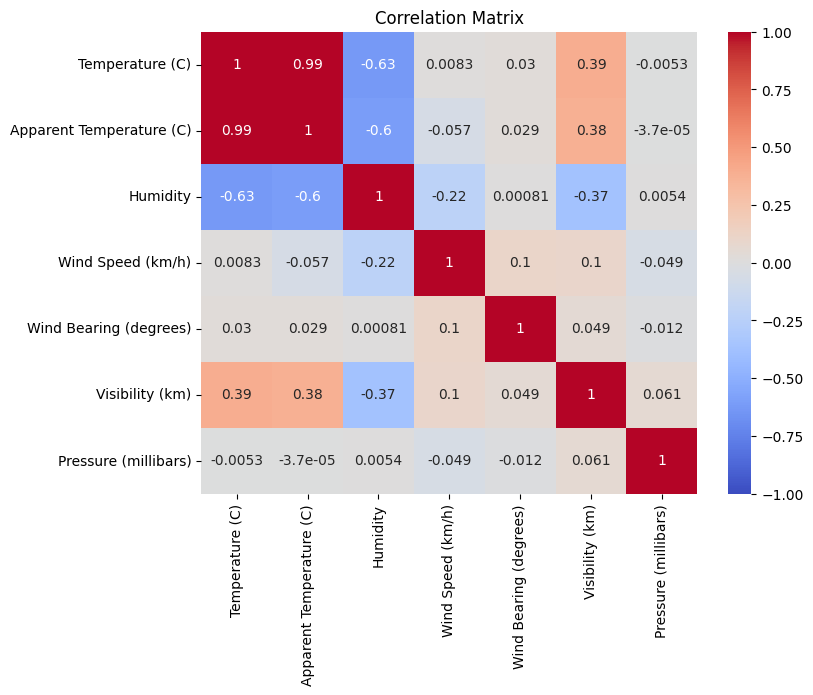

In [75]:
# Calculate the correlation matrix of the dataframe 'df'
# The corr() function calculates the pairwise correlation of columns, excluding NA/null values
# The numeric_only argument is set to True to include only numeric columns in the correlation calculation

correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap to visualize the correlation matrix
# The figure size is set to 8x6 inches
plt.figure(figsize=(8, 6))

# The heatmap() function from seaborn is used to plot the correlation matrix
# The annot argument is set to True to write the data value in each cell
# The cmap argument is set to 'coolwarm' to use the coolwarm colormap
# The vmin and vmax arguments are set to -1 and 1 respectively to anchor the colormap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the title of the heatmap
plt.title('Correlation Matrix')

# Display the plot
plt.show()

In [112]:
#Temperature is ~~ Temperature apparente so we gonna drop the Apparente Temperature
df.drop('Apparent Temperature (C)' , axis = 1 , inplace = True)

In [114]:
# Aggregating the data

# Group the dataframe 'df' by 'Formatted Date' and aggregate the other columns
# The groupby() function is used to group the dataframe by 'Formatted Date'
# The agg() function is used to apply different aggregation functions to different columns
# 'first' is used for 'Daily Summary' and 'Precip Type' to get the first value in each group
# 'mean' is used for the numeric columns to get the average value in each group
grouped = df.groupby(df['Formatted Date']).agg(
    {'Daily Summary': 'first',
     'Precip Type': 'first',
     'Temperature (C)': 'mean',
     'Humidity': 'mean',
     'Wind Speed (km/h)' : 'mean',
     'Wind Bearing (degrees)' : 'mean',
     'Visibility (km)' : 'mean',
     'Pressure (millibars)' : 'mean'
     })

# The result is a new DataFrame with the 'Formatted Date' column and aggregated values for the specified columns.

# Display the first 24 rows of the aggregated dataframe
grouped.head(24)

,Daily Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31,Mostly cloudy throughout the day.,rain,0.577778,0.890000,17.114300,140.000000,9.982000,1016.660000
2006-01-01,Mostly cloudy throughout the day.,rain,4.075000,0.817083,21.229192,142.750000,11.348487,1011.985000
2006-01-02,Overcast throughout the day.,rain,5.263194,0.847083,17.824713,164.583333,8.492079,1010.384167
2006-01-03,Mostly cloudy throughout the day.,rain,2.340509,0.897083,7.726658,252.541667,9.223958,1021.170833
2006-01-04,Overcast throughout the day.,rain,2.251852,0.906667,12.152817,35.000000,8.352546,981.770833
2006-01-05,Foggy in the morning.,rain,2.703935,0.951250,8.991179,139.875000,4.308092,935.873750
2006-01-06,Foggy until morning.,rain,2.550463,0.945833,5.729588,269.500000,4.635458,1023.645833
2006-01-07,Foggy starting overnight continuing until morn...,rain,0.877083,0.935833,6.589596,102.041667,4.585817,1030.223750
2006-01-08,Partly cloudy in the afternoon.,snow,-1.231713,0.868750,5.397525,113.916667,8.694671,1035.481250


In [115]:
len(grouped['Daily Summary'])

4009

In [116]:
# Calculate the percentage of each 'Daily Summary' value in the original DataFrame
percentage_per_summary = grouped['Daily Summary'].value_counts() / len(grouped)

# Create a mask to filter rows where the percentage is greater than 1%
mask = grouped['Daily Summary'].apply(lambda x: percentage_per_summary.get(x, 0)) > 0.01

# Apply the mask to the grouped DataFrame
filtered_grouped = grouped[mask]

In [118]:
# Discretization of continuous values

# Discretize the 'Temperature (C)' column into 5 equal-sized bins
# The cut() function is used to bin values into discrete intervals
# The labels argument is used to specify the labels for the resulting bins
temp = pd.cut(filtered_grouped['Temperature (C)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])

# Repeat the same process for the 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', and 'Pressure (millibars)' columns
humidity = pd.cut(filtered_grouped['Humidity'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
wind_speed = pd.cut(filtered_grouped['Wind Speed (km/h)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
wind_bearing = pd.cut(filtered_grouped['Wind Bearing (degrees)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
visibility = pd.cut(filtered_grouped['Visibility (km)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])
pressure = pd.cut(filtered_grouped['Pressure (millibars)'], 5, labels=["Very low", "Low", "Medium", "High", "Very high"])

# Get the column names of the dataframe 'filtered_grouped'
columns_names = filtered_grouped.columns

# Display the column names
columns_names

Index(['Daily Summary', 'Precip Type', 'Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'],
      dtype='object')

In [119]:
# Create a dictionary where the keys are the column names and the values are the corresponding Series
# The first two columns are taken directly from the 'filtered_grouped' dataframe
# The remaining columns are the discretized versions created in the previous step
d = { columns_names[0]: filtered_grouped[columns_names[0]],
     columns_names[1]: filtered_grouped[columns_names[1]],
     columns_names[2]: temp,
     columns_names[3]: humidity,
     columns_names[4]: wind_speed,
     columns_names[5]: wind_bearing,
     columns_names[6]: visibility,
     columns_names[7]: pressure,
    }

# Create a new dataframe 'new_df' from the dictionary 'd'
# The DataFrame() constructor is used to convert the dictionary into a dataframe
new_df = pd.DataFrame(data=d)

# Display the new dataframe
new_df

,Daily Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31,Mostly cloudy throughout the day.,rain,Low,Very high,High,Medium,High,Very high
2006-01-01,Mostly cloudy throughout the day.,rain,Medium,High,Very high,Medium,High,Very high
2006-01-02,Overcast throughout the day.,rain,Medium,High,High,Medium,Medium,Very high
2006-01-03,Mostly cloudy throughout the day.,rain,Low,Very high,Low,High,Medium,Very high
2006-01-04,Overcast throughout the day.,rain,Low,Very high,Medium,Very low,Medium,Very high
...,...,...,...,...,...,...,...,...
2016-12-27,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high
2016-12-28,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high
2016-12-29,Mostly cloudy throughout the day.,snow,Low,Very high,Medium,Medium,Medium,Very high


# Step 3 & 4: Creating a Bayesian Network and Training the Data
-Defining the structure of the Bayesian Network based on variable dependencies

-Specifying conditional probability distributions for each node in the network

-Utilizing a probabilistic graphical model to represent relationships between variables

-Adjusting parameters for the network to improve accuracy

-Spliting the dataset into training and testing sets to evaluate model performance

-Training the Bayesian Network using the training data


In [121]:
# Split the dataframe 'new_df' into a training set and a test set
# The first 3000 rows are used as the training set
# The remaining rows (from index 3000 onwards) are used as the test set
data_train = new_df[:3000]
data_test = new_df[3000:]

# Get the column names of the training set
data_train.columns

Index(['Daily Summary', 'Precip Type', 'Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'],
      dtype='object')

In [122]:
# HillClimbSearch is used to perform a greedy hill climb search to find the model structure that maximizes the score
# BicScore is used to compute the Bayesian Information Criterion (BIC) score for a model

# Create an instance of the HillClimbSearch class with the dataframe 'new_df'
estimator = HillClimbSearch(new_df)

# Create an instance of the BicScore class with the dataframe 'new_df'
scoring_method = BicScore(new_df)

# Use the estimate() method of the HillClimbSearch instance to find the model structure that maximizes the BIC score
# The scoring_method argument is set to the BicScore instance
best_model = estimator.estimate(scoring_method=scoring_method)

# Print the edges in the learned model
# The edges() method of the model instance is used to get the edges
print("Edges in the learned model:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\tmmot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
C:\Users\tmmot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
C:\Users\tmmot\AppData\Local\

Edges in the learned model:
[('Precip Type', 'Visibility (km)'), ('Temperature (C)', 'Precip Type'), ('Temperature (C)', 'Humidity'), ('Humidity', 'Visibility (km)'), ('Wind Speed (km/h)', 'Temperature (C)'), ('Wind Bearing (degrees)', 'Wind Speed (km/h)'), ('Visibility (km)', 'Daily Summary')]


The following lines represent the edges in the learned model.
Each tuple represents a directed edge from the first variable to the second.

'Precip Type' influences 'Visibility (km)'
This suggests that the type of precipitation (rain, snow, etc.) has an effect on visibility.

'Temperature (C)' influences 'Precip Type' and 'Humidity'
This suggests that the temperature has an effect on both the type of precipitation and the humidity.

'Humidity' influences 'Visibility (km)'
This suggests that the level of humidity has an effect on visibility.

'Wind Speed (km/h)' influences 'Temperature (C)'
This suggests that the wind speed has an effect on the temperature.

'Wind Bearing (degrees)' influences 'Wind Speed (km/h)'
This suggests that the wind bearing (the direction from which it comes) has an effect on the wind speed.

'Visibility (km)' influences 'Daily Summary'
This suggests that visibility has an effect on the daily summary, which could be a summary of the weather conditions for the day.

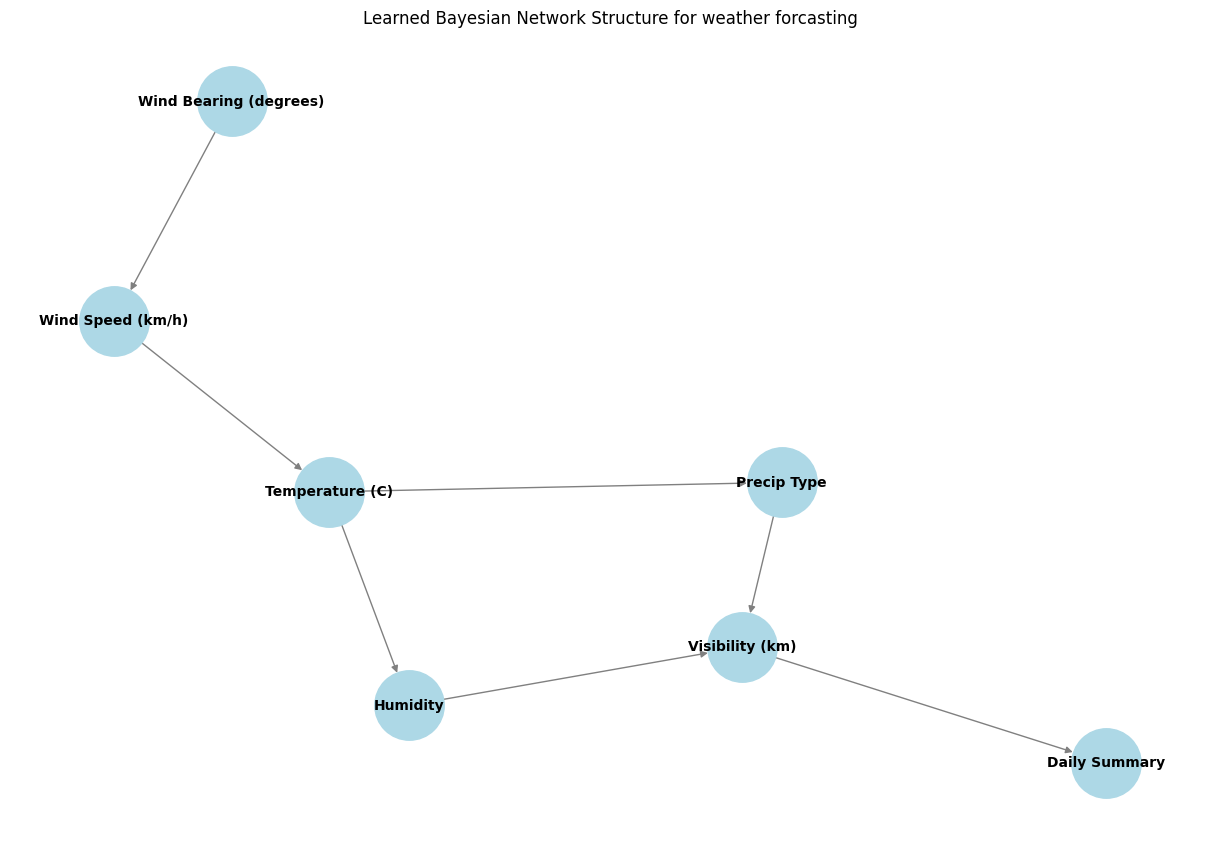

In [123]:
# Import matplotlib.pyplot for data visualization
import matplotlib.pyplot as plt
# Import networkx for creating and manipulating complex networks (like our Bayesian network)
import networkx as nx

# Create a directed graph object
G = nx.DiGraph()

# Add edges to the graph from the best model's edges
G.add_edges_from(best_model.edges())

# Set the figure size for the plot
plt.figure(figsize=(12, 8))

# Generate a spring layout position for the graph. This uses Fruchterman-Reingold force-directed algorithm to position nodes.
pos = nx.spring_layout(G)

# Draw the graph using the spring layout position. Nodes are light blue, edges are gray, node size is 2500, font size is 10, and font weight is bold.
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2500, font_size=10, font_weight='bold')

# Set the title of the plot
plt.title('Learned Bayesian Network Structure for weather forcasting')

# Display the plot
plt.show()

In [124]:
# Import BayesianNetwork from pgmpy.models
# pgmpy is a python library for working with Probabilistic Graphical Models.
from pgmpy.models import BayesianNetwork

# Define the structure of the Bayesian Network as a list of edges.
# Each edge is a tuple where the first element is the parent node and the second element is the child node.
# This structure represents the dependencies between different variables.
model = BayesianNetwork([
    ('Precip Type', 'Visibility (km)'),
    ('Temperature (C)', 'Precip Type'),
    ('Temperature (C)', 'Humidity'),
    ('Humidity', 'Visibility (km)'),
    ('Wind Speed (km/h)', 'Temperature (C)'),
    ('Wind Bearing (degrees)', 'Wind Speed (km/h)'),
    ('Visibility (km)', 'Daily Summary')
])

# Fit the model to the training data.
# This step will estimate the conditional probability distributions for each variable given its parents.
model.fit(data_train)

In [125]:
data_train

,Daily Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31,Mostly cloudy throughout the day.,rain,Low,Very high,High,Medium,High,Very high
2006-01-01,Mostly cloudy throughout the day.,rain,Medium,High,Very high,Medium,High,Very high
2006-01-02,Overcast throughout the day.,rain,Medium,High,High,Medium,Medium,Very high
2006-01-03,Mostly cloudy throughout the day.,rain,Low,Very high,Low,High,Medium,Very high
2006-01-04,Overcast throughout the day.,rain,Low,Very high,Medium,Very low,Medium,Very high
...,...,...,...,...,...,...,...,...
2016-05-19,Mostly cloudy throughout the day.,rain,High,High,Low,Low,Very high,Very high
2016-05-20,Partly cloudy throughout the day.,rain,High,Medium,Medium,Low,Very high,Very high
2016-05-21,Partly cloudy starting in the morning.,rain,High,Medium,Medium,Medium,Very high,Very high


In [126]:
# Retrieve the Conditional Probability Distributions (CPDs) of all the nodes in the model.
# A CPD for a node represents the probability of each state of the node given each combination of states of its parent nodes.
cpds = model.get_cpds()

# Loop through each CPD
for cpd in cpds:
    # Print the variable name for the CPD
    print(f"CPD for {cpd.variable}:")

    # Print the CPD itself
    # This will show the probability distribution of the variable given the states of its parents.
    print(cpd)

    # Print a newline for readability
    print("\n")

CPD for Precip Type:
+-------------------+-----+---------------------------+
| Temperature (C)   | ... | Temperature (C)(Very low) |
+-------------------+-----+---------------------------+
| Precip Type(rain) | ... | 0.0                       |
+-------------------+-----+---------------------------+
| Precip Type(snow) | ... | 1.0                       |
+-------------------+-----+---------------------------+


CPD for Visibility (km):
+----------------------------+-----+--------------------+
| Humidity                   | ... | Humidity(Very low) |
+----------------------------+-----+--------------------+
| Precip Type                | ... | Precip Type(snow)  |
+----------------------------+-----+--------------------+
| Visibility (km)(High)      | ... | 1.0                |
+----------------------------+-----+--------------------+
| Visibility (km)(Low)       | ... | 0.0                |
+----------------------------+-----+--------------------+
| Visibility (km)(Medium)    | ... | 0

# Step 5: Predicting the Weather
-Use the trained Bayesian Network to predict weather conditions for a given day

-Evaluate the model's performance on the testing set

In [127]:
# Select the test data from the DataFrame 'new_df'. 
# Here, all rows from index 3000 onwards are selected for testing.
data_test = new_df[3000:]

# Get the true values for 'Daily Summary' from the test data.
# These are the values that the model's predictions will be compared against.
true_y = data_test['Daily Summary'].values

# Drop the 'Daily Summary' and 'Pressure (millibars)' columns from the test data.
# 'inplace=True' means that the changes are made directly to the data_test DataFrame.
# 'axis=1' indicates that columns (not rows) should be dropped.
data_test.drop({'Daily Summary' , 'Pressure (millibars)'} , axis = 1 , inplace=True)

# Predict the 'Daily Summary' for the test data using the model.
# This line is commented out, so it won't be executed.
#y_pred = model.predict(data_test)


C:\Users\tmmot\AppData\Local\Temp\ipykernel_13200\1069988205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop({'Daily Summary' , 'Pressure (millibars)'} , axis = 1 , inplace=True)


In [128]:
data_test

,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km)
Formatted Date,,,,,,
2016-05-24,rain,High,High,Medium,Very high,High
2016-05-25,rain,High,High,High,Very high,High
2016-05-26,rain,High,Medium,Low,Very high,Very high
2016-05-27,rain,High,Medium,Very low,Medium,Very high
2016-05-28,rain,Very high,Medium,Low,Low,Very high
...,...,...,...,...,...,...
2016-12-27,snow,Low,Very high,Medium,Medium,Medium
2016-12-28,snow,Low,Very high,Medium,Medium,Medium
2016-12-29,snow,Low,Very high,Medium,Medium,Medium


In [129]:
# Use the model to predict the 'Daily Summary' for the test data.
# The predict method takes a DataFrame of features and returns a DataFrame of predictions.
# The result is stored in the variable 'y_pred'.
y_pred = model.predict(data_test)

100%|██████████| 89/89 [00:00<00:00, 1540.95it/s]


In [131]:
# Access the nodes of the Bayesian Network model.
# The nodes represent the variables in the model.
model.nodes


NodeView(('Precip Type', 'Visibility (km)', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Daily Summary'))

In [132]:
data_test.columns

Index(['Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)'],
      dtype='object')

In [136]:
# Calculate the accuracy of the model's predictions.
# The accuracy_score function compares the true values (true_y) with the predicted values (y_pred).
# The result is stored in the variable 'accuracy'.
accuracy = accuracy_score(true_y, y_pred)

# Print the accuracy of the model.
print("Accuracy:", accuracy)

Accuracy: 0.4975124378109453


# Final Accuracy Evaluation
---
The trained Bayesian Network achieved an accuracy of 49.75% on the testing set.

The obtained accuracy indicates that the model's predictions are slightly better than random chance.

While the accuracy is below ideal levels, it's crucial to consider the complexity of weather prediction,

which involves various factors and uncertainties. Further analysis and potential enhancements to the model, such as refining feature selection or exploring more sophisticated Bayesian Network structures,could be explored to improve predictive performance. Additionally, assessing other metrics like precision, recall, or F1 score could provide a more nuanced understanding of the model's strengths and weaknesses in different weather prediction scenarios. Continuous refinement and iteration may lead to enhancements and a more robust weather prediction system.